# Practicum Summer 2021

**Author: Gowsiya Shek**

This notebook contains code to read tweets and cluster them, which is challenge #1 for Summer 2021 Practicum Piper Gradient project.



# Load Dataset

Load offline twitter dataset provided for the project.

In [1]:
!python --version

Python 3.8.3


In [2]:
!pip install -U gensim
!pip install pyLDAvis==2.1.2

  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.0
    Uninstalling scipy-1.5.0:
      Successfully uninstalled scipy-1.5.0


ERROR: scipy 1.10.1 has requirement numpy<1.27.0,>=1.19.5, but you'll have numpy 1.18.5 which is incompatible.


  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97716 sha256=befeb78e99b4be979fabf3cd728a4abd53e2b2e28debf831943d240c05a7a46f
  Stored in directory: c:\users\gowsi\appdata\local\pip\cache\wheels\31\8c\a0\24a443892f2134e691d59c8c6c35e19821e02f85e49871f8fd
Successfully built pyLDAvis


In [4]:
import pandas as pd
import numpy as np
import time
# from google.colab import drive

In [3]:
# mount google drive-  use this if your data is large and stored in google drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#Large - out of 25.08M, 7084 are unique
''' Replace the csv path with your drive location where file is stored'''
lrg_tweets = 'c1_toy_dataset.csv'
df = pd.read_csv(lrg_tweets, error_bad_lines=False)
print(len(df.index))
print(len(df.id.unique()))
print(df.head(3))


21
5
   Unnamed: 0     created_at            id  reply_to_id   screen_name  \
0           0  6/4/2021 0:26  1.400610e+18          NaN  livingjoyful   
1           1  6/4/2021 0:26  1.400610e+18          NaN   robjacobs59   
2           2  6/4/2021 0:26  1.400610e+18          NaN      RawStory   

   coordinates  place  retweet_count  favorite_count lang  ...  \
0          NaN    NaN              2               0   en  ...   
1          NaN    NaN            514               0   en  ...   
2          NaN    NaN              0               1   en  ...   

         user_loc                                   user_description  \
0   United States  b'#Resistance. #FBR #AntiFascist #BLM\xf0\x9f\...   
1     Nevada, USA  b'Certified Personal Trainer(CPT) National Cou...   
2  Washington, DC  b'The official Twitter of http://t.co/HJOFeYodXw'   

   verified followers_count friends_count  favourites_count  statuses_count  \
0     False            4041          4401             56114          

In [7]:
# Copying so that original data is in a dataframe in case we need to check for debugging
data = df.copy(deep=True)
data['text'][1]

"b'RT @PramilaJayapal: We\\xe2\\x80\\x99ve seen this movie before.\\n\\nRepublicans will ask for concession after concession, and STILL not vote for the watered-down bill they demanded.\\n\\nLet\\xe2\\x80\\x99s learn from history. It\\xe2\\x80\\x99s time for us to go big, bold, and on our own on infrastructure. Let\\xe2\\x80\\x99s deliver for the people.'"

## Data Cleaning
The given datasets (small, medium & large) are comprised of very much unstructured tweets which should be preprocessed to make an NLP model. In this section, we will use *Removal of punctuations, Tokenizatoin and Removal of commonly used words (stopwords)* for preprocessing the raw data, using some of the popular open-source libraries.

We clean text by using lambda function and clean RT, link, punctuation characters, convert to lowercase and remove stopwords.

**Imports**
- *nltk*: suite of libraries and programs for symbolic and statistical nlp for English.
- *from nltk.corpus stopwords*: A list of really common words, like articles, pronouns, prepositions, and conjunctions that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query. 
- *from nltk.tokenize import WordPunctTokenizer*: return the tokens from a string of alphabetic or non-alphabetic character.
- *from bs4 import BeautifulSoup*: For parsing
- *import re*: For regular expression matching operations
- *matplotlib.pyplot:* For plotting


In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

C:\Users\gowsi\anaconda3\lib\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.18.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
# Important for using stopwords, otherwise the next cell will error out
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gowsi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gowsi\AppData\Roaming\nltk_data...


True

In [10]:
# Removal of punctuation
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+' # Tweets starting with @
pat2 = r'#[A-Za-z0-9]+' # Tweets starting with #
pat3 = r'RT @[A-Za-z0-9]+' # retweets string RT in the tweets
pat4 = r'https?://[A-Za-z0-9./]+' # URLs in tweets
pat5 = r'(\\x(.){2})' # For x__ strings in tweets 
pat6 = r'(\\n)' # For newline in tweets

combined_pat = r'|'.join((pat1, pat2, pat3, pat4, pat5, pat6))

""" tweet_cleaner function cleans the tweets by removing special characters, emojis that are converted to text etc
    
    parameters
    -----------
    text: tweets from the data

    return
    -------
    Cleaned words
"""
def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml') # set lxml paserse
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped) # apply regular expressions on tweet text
    try:
        clean = stripped.decode("utf-8").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()

    # During the letters_only process two lines above, it has created unnecessay white spaces, tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

# call the tweet_cleaner on tweet text
ts1 = time.time()
df['text'] = df['text'].map(lambda x: tweet_cleaner(x))
df["text"] = df.text.str.lower()

# Remove stop words from cleaned tweets
additional  = ['rt','rts','retweet', 'b']
sw = set().union(stopwords.words('english'),additional)
df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if w not in sw]))

print('Time taken for data cleaning: %.2f seconds' %(time.time()-ts1))

Time taken for data cleaning: 0.02 seconds


In [11]:
# Check the cleaned data by displaying one of the tweet
df['text'][4]

'weve seen movie republicans ask concession concession still vote watered bill demanded lets learn history time us go big bold infrastructure lets deliver people'

# 1. Exploratory Data Analysis


#### View missing values and frequency of tweets by different handles and sources

**Import**

*seaborn:* Library for great visualizations

In [22]:
# !pip install seaborn
# !pip install numpy --force-reinstall

In [21]:
import seaborn as sns

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 80 from PyObject

NameError: name 'sns' is not defined

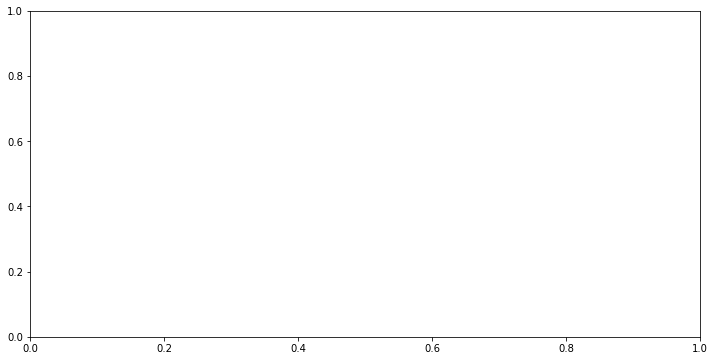

In [23]:
# Plot for missing values across different columns
# Ref [4]
plt.subplots(figsize=(12,6))
missing_graph = sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap="PuBu")
plt.show()

In [11]:
# Ref - [4]
"""
plot_frequency_charts function plots frequency of User Names, Tweet Sources etc
    
    parameters
    -----------
    df: dataframe containing the data
    feature: column from dataframe for which frequency of tweets to be plotted
    title: X-axis lable to be displayed
"""
def plot_frequency_charts(df, feature, title):
    freq_df = pd.DataFrame()
    freq_df[feature] = df[feature]
    
    f, ax = plt.subplots(1,1, figsize=(16,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')  # Sort and pick the top 20 values for plotting
    g.set_title("Number and percentage of {}".format(title))

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height + 3, '{:1.2f}%'.format(100*height/total), ha="center") 

    plt.title('Frequency of *{}* Tweeting about Infrastructure Bill'.format(feature))
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel(title, fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


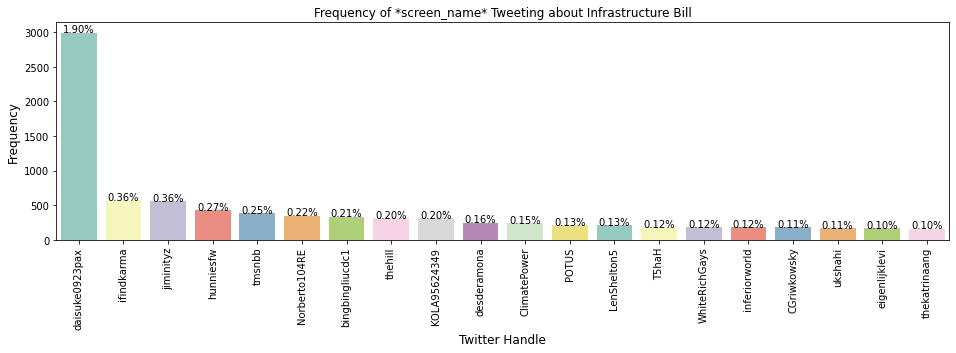

In [12]:
# Top 20 handles based on frequency of tweets
plot_frequency_charts(df, feature='screen_name', title='Twitter Handle')

The chart above shows how a single user is responsible highest number of tweets, this is the kind of behavior that leads to 'Response bias'.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


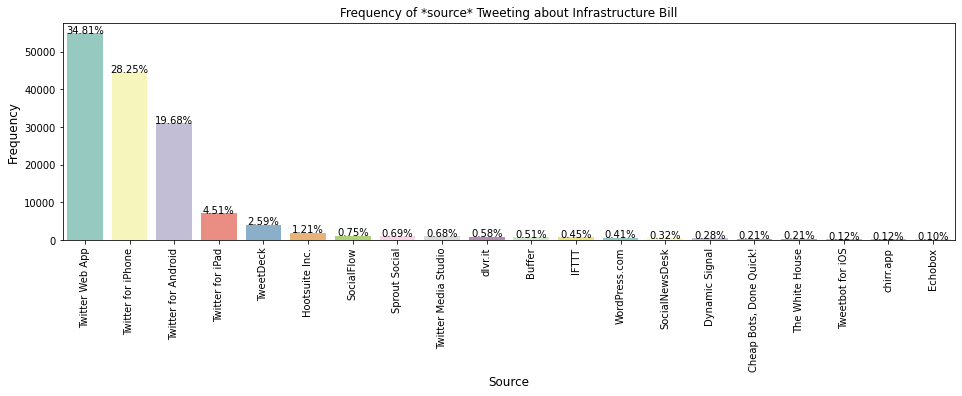

In [13]:
# Top 20 sources based on frequency of tweets
plot_frequency_charts(df, feature='source', title='Source')

The chart above shows that majority of tweets are from Twitter's web app, challenging the common assumption that people are tweeting mostly from phone.

#### View bigrams(2 words) as bar graph

**Imports**

*CountVectorizer from sklearn.feature_extraction.text*: transforms a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text

*plotly.graph_objects*: module that contains an automatically-generated hierarchy of Python classes which represent non-leaf nodes in this figure schema


In [14]:
from sklearn.feature_extraction.text import CountVectorizer
import plotly.graph_objects as go

In [15]:
# Ref - [3]
"""
get_top_n_bigram function finds the bigram and returns n of them to the caller
    
    parameters
    -----------
    corpus: tweets from the data
    n: top n bigrams

"""
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['text'], 30)
ngram_df = pd.DataFrame(common_words, columns = ['bigram' , 'tweets'])

fig = go.Figure([go.Bar(x=ngram_df['bigram'], y=ngram_df['tweets'])])
fig.update_layout(title=go.layout.Title(text="Top 30 bigrams in the tweet text"))
fig.show()

#### Draw Word Cloud

**Import**:

*WordCloud from wordcloud*: to create word cloud that displays words based on their frequency in the dataset

Note: Stopwords are skipped because the text is cleaned of any stop words during the data cleaning step. For large dataset wordcloud takes about 20 secs to complete

In [16]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

There are 19392716 words in all of the tweets.


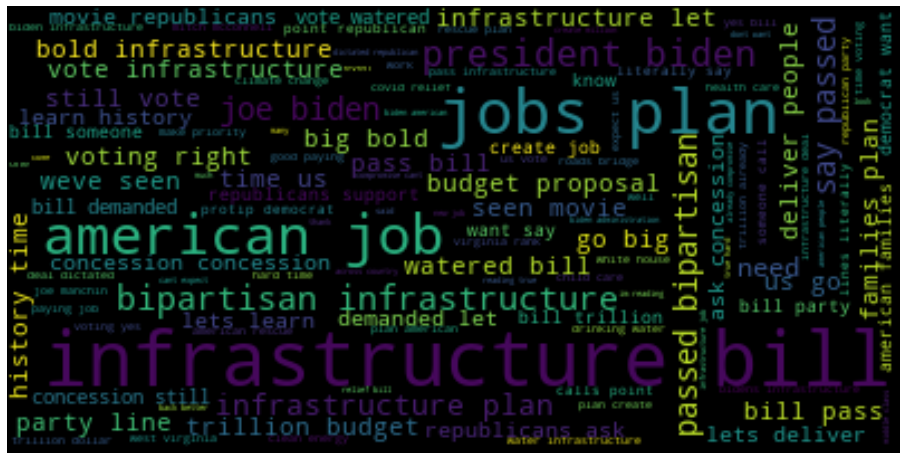

In [17]:
text = " ".join(tweet for tweet in df.text)
print ("There are {} words in all of the tweets.".format(len(text)))

""" 
Wordcloud object to generate word cloud

    WordCloud
    ---------- 
    Object can be passed different parameters such as max_font_size, max_words, background_color etc

"""
wordcloud = WordCloud(max_font_size=45, max_words=2000, background_color="black").generate(text)

# Display the generated image
plt.figure(figsize=(16,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The word cloud and bigram bar chart match with each other on the important topics for the **large** dataset.

# 2. Semantic Relationship 
Semantic relationship is the process of drawing meaning from text. 
We are using sentiment analysis and lemmatization techniques before applying topic modeling on the tweet text.

#### Sentiment Analysis

For sentiment analysis, large dataset would be too slow without using list comprehension which was discovered during implementation and changed.

**Imports**

*SentimentIntensityAnalyzer*: NLTK's built-in, pretrained sentiment analyzer called VADER (Valence Aware Dictionary and sEntiment Reasoner) [2].

The negative, neutral, and positive scores are related: They all add up to 1 and can’t be negative. The compound score is calculated differently, it’s not just an average, and it can range from -1 to 1.

Note: Since VADER is pretrained, you can get results more quickly than with many other analyzers. VADER is best suited for language used in social media, like short sentences with some slang and abbreviations. However it’s less accurate when rating longer, structured sentences, but it’s often a good launching point.

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [19]:
num_tweets = len(df.index)   # to be used for percentage calc
analyzer = SentimentIntensityAnalyzer()  # Create an instance

In [20]:
# Calculate percentage of tweets in certain category
def percentage(part,whole):
 return 100 * float(part)/float(whole)

ts2 = time.process_time()

# Using list comprehension and polarity_score to get polarity score for positive, negative and neutral tweets.
""" 
  polarity_scores(tweet.text) - function to classify tweets into positive, negative, compound and neutral sentiment. You’ll get back a dictionary of different scores.
  Ex: a = 'This was a good movie.'
  SentimentIntensityAnalyzer().polarity_scores(a)
  OUTPUT:  {'compound': 0.4404, 'neg': 0.0, 'neu': 0.508, 'pos': 0.492} 
"""
df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in df['text']]
df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in df['text']]
df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in df['text']]
df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in df['text']]

negative_list = df[df.apply(lambda x: x['neg'] > x['pos'], axis = 1)]['neg']
positive_list = df[df.apply(lambda x: x['pos'] > x['neg'], axis = 1)]['pos']
neutral_list = df[df.apply(lambda x: x['pos'] == x['neg'], axis = 1)]['neu']

print('Time taken for sentiment analysis: %.2f seconds' %(time.process_time() - ts2))

Time taken for sentiment analysis: 172.69 seconds


In [21]:
# Create numbers that can be used for plotting visualization 
positive = format(percentage(len(positive_list), num_tweets), '.1f')
negative = format(percentage(len(negative_list), num_tweets), '.1f')
neutral = format(percentage(len(neutral_list), num_tweets), '.1f')

print("Total Tweets: ",num_tweets)
print("positive number: ",len(positive_list))
print("negative number: ", len(negative_list))
print("neutral number: ",len(neutral_list))

Total Tweets:  157784
positive number:  89038
negative number:  39043
neutral number:  29703


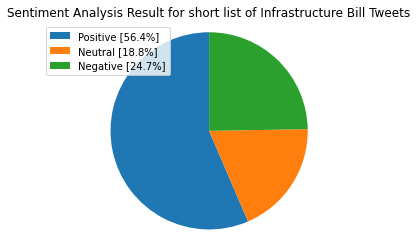

In [22]:
# Creating PieCart using the data created in previous cell
labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
patches, texts = plt.pie(sizes, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for short list of Infrastructure Bill Tweets")
plt.axis('equal')
plt.show()

#### Lemmatization

Stemming and lemmatization are normalization techniques, and it is recommended to use only one approach to normalize. Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item.

I have used Lemmatization below so we retain the meaning of the word and not just stem the end without considering actual vocabulary.

In [ ]:
# Download the necessary libraries
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

**Imports**

*WordNetLemmatizer from nltk.stem.wordnet*: library that uses the *WordNet* database to lookup lemmas of words.

In [24]:
from nltk.stem.wordnet import WordNetLemmatizer

In [25]:
# Lemmatize
lmtzr = WordNetLemmatizer()
ts3 = time.time()

"""
lmtzr.lemmatize(word) - function takes word as input and returns the lemma of the word.
Example: lmtzr.lemmatize('communities') -> community
"""
df['text'] = df['text'].apply(lambda x: ' '.join([lmtzr.lemmatize(word) for word in x.split()]))
print('Time taken for Lemmatization: %.2f seconds'%(time.time()-ts3))

Time taken for Lemmatization: 14.63 seconds


# 3. Topic Modeling (Clustering categories)
Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body. Intuitively, given that a document is about a particular topic, one would expect particular words to appear in the document more or less frequently

We will be exploring 2 popular topic modeling techniques - Non-negative Matrix Factorization (NMF) and Latent Dirichlet Allocation (LDA) in this section.

### 3.a Non-negative Matrix Factorization (NMF)



Reference: [6]

NMF uses term frequencies
1. NMF answers the questions - to what extent a whole is a sum of its parts? and how do we use these parts?
2. We convert a corpus of documents into numbers to answer questions like:
  - What are the prevailing topics in this corpus?
  - To what extent is each topic important in each document?
  - How well do these extracted topics describe the original document?
  - How similar is one document to another?
3. Corpus - In our case is tweet text, term is word. 
Corpus is composed set of topics embedded in its documents, a document is composed of heirarchy of topics, a topic is composed of heirarchy of terms.


NMF is non-negative matrix approximation where a matrix V is factorized into two matrices W and H, with property that all 3 matrices have no negative elements.

Let matrix **V** be the product of the matrices **W** and **H**,

                           V=WH

Matrix multiplication can be implemented as computing the column vectors of V, as linear combinations of the column vectors in W, using coefficients supplied by columns of H. That is, each column of V can be computed as follows:

                        v_i=Wh_i
where v_i is the i-th column vector of the product matrix V and h_i is the i-th column vector of the matrix H.

NMF has an inherent clustering property i.e it automatically clusters the columns of input data V = (v_1,…v_n)

More specifically, the approximation of V by V≈WH is achieved by finding W and H that minimize the error function *‖V=WH‖_F* subject to *W≥0, H≥0*.



Tf-IDF is used in order to give greater value to more unique terms


**Imports**

*TfidfVectorizer*: creates term-document matrix to pass into NMF as input.

*NMF from sklearn.decomposition*: sklearn NMF module

###### 1] Using gensim NMF to choose best number of topics

**Imports**

*Dictionary from gensim.corpora*: implements a dictionary, which is a mapping between words and their integer ids

*CoherenceModel from gensim.models*: Calculates topic coherence for topic models, typically used for evaluation of topic models

*Nmf from gensim.models.nmf*: Implement NMF model

*itemgetter from operator*: Return a callable object that fetches item from its operand using the getitem() method.

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.models.nmf import Nmf
from operator import itemgetter

In [27]:
# Code ref: [7]

'''Use Gensim's NMF to get the best num of topics via coherence score'''
ts4 = time.time()
texts = [d.split() for d in df['text']]

# Create a dictionary - In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

"""
    dictionary.filter_extremes() - Filter out extremes to limit the number of features

    parameters
    ----------
    no_below - filter token that appear in less than no_below documents
    no_above - filter tokens that appear in more than no_above
"""
dictionary.filter_extremes(no_below=3, no_above=0.85)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
""" Create number of topic to plot from 10 to 35 with step size 5"""
topic_nums = list(np.arange(10, 35 + 1, 5))

# Run the nmf model and calculate the coherence score for each number of topics
coherence_scores = []

""" Gensim Nmf: Other than w_max_iter setting to 300, all other parameters are left default from a code exmaple """
for num in topic_nums:
    nmf = Nmf( corpus=corpus, num_topics=num, id2word=dictionary,
               chunksize=2000, passes=5, kappa=.1, minimum_probability=0.01,
               w_max_iter=300, w_stop_condition=0.0001, h_max_iter=100, h_stop_condition=0.001,
               eval_every=10, normalize=True, random_state=42 )
    
    # Run the coherence model to get the coherence score
    """Using c_v here which ranges from 0 to 1 with 1 being perfectly coherent topics"""
    cm = CoherenceModel(model=nmf, texts=texts, dictionary=dictionary, coherence='c_v' )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the coherence scores
scores = list(zip(topic_nums, coherence_scores))

print('Time taken to finish best_topic_num selection: %.2f seconds' %(time.time() - ts4))

Time taken to finish best_topic_num selection: 641.87 seconds


In [28]:
# Sort scores in descending order and get the topics for higest score
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

35


(array([0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57]),
 <a list of 7 Text major ticklabel objects>)

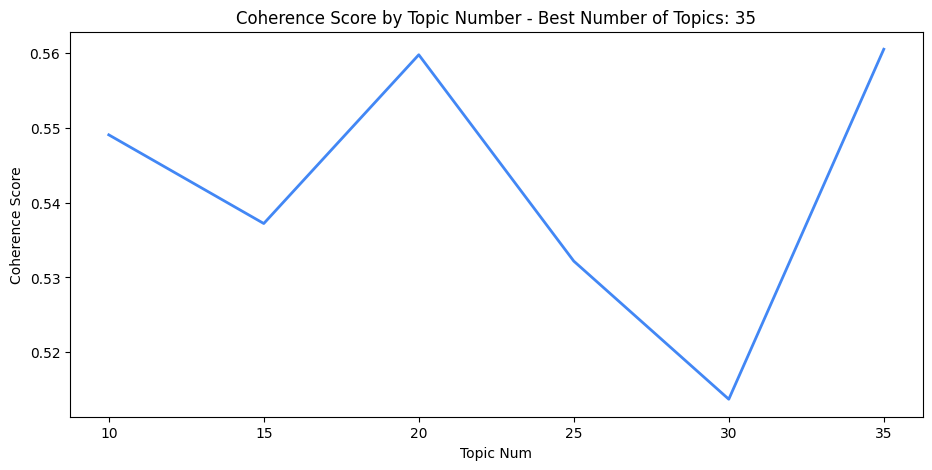

In [29]:
# Plot the results
fig = plt.figure(figsize=(11, 5))

plt.plot(topic_nums, coherence_scores, linewidth=2, color='#4287f5')

plt.xlabel("Topic Num", fontsize=10)
plt.ylabel("Coherence Score", fontsize=10)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=12)
plt.xticks(np.arange(10, max(topic_nums) + 1, 5), fontsize=10)
plt.yticks(fontsize=10)

The above graph shows good coherence for topics 20 and 35. Though the best topics returned by the program is 35, I am using 20 which seems like a reasonable number with almost same coherence score.

###### 2] Using sklearn to create topics

**Imports**

*TfidfVectorizer sklearn.feature_extraction.text*: To convert a collection of raw documents to a matrix of TF-IDF features.

*NMF from sklearn.decomposition*: Non-negative Matrix Normalization algorithm library.

*RegexpTokenizer from nltk.tokenize*: Splits a string into substrings using a regular expression.


In [30]:
# Code Rerence - [5] 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from nltk.tokenize import RegexpTokenizer

In [31]:
ts5 = time.time()

texts = [d.split() for d in df['text']]

# Vectorize the corpus
''' max_df: ignore terms that have a document frequency strictly higher than 95%, 
    min_df: ignore terms that have a document frequency strictly lower than 10 
    ngram_range: given (1,2) to make two word sequences are conrreclty considered'''

tfidf_vectorizer = TfidfVectorizer(min_df=10, max_df=0.95, ngram_range=(1,2), preprocessor=' '.join)

# calculate the feature matrix
tfidf_feature_matrix = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fnames = tfidf_vectorizer.get_feature_names()

# Get V matrix
V = tfidf_vectorizer.transform(texts)

print('Time taken to create tfidf matrix: %.2f seconds' %(time.time() - ts5))

Time taken to create tfidf matrix: 16.54 seconds


In [32]:
# tfidf_feature_matrix
import numpy
with numpy.printoptions(threshold=numpy.inf):
    print(V)
# V

  (0, 36405)	0.3864739259186969
  (0, 34257)	0.3121728475747408
  (0, 33183)	0.10713197344025235
  (0, 29620)	0.21722453302240846
  (0, 27733)	0.5619184707750539
  (0, 21644)	0.10869274352125267
  (0, 21356)	0.3121728475747408
  (0, 14952)	0.17632796749656704
  (0, 14816)	0.14903544675675426
  (0, 11317)	0.207309160606318
  (0, 10293)	0.1627578539587283
  (0, 978)	0.35751072904088205
  (0, 888)	0.1375487124601365
  (1, 36831)	0.18358200074902462
  (1, 36759)	0.08817312904646596
  (1, 35701)	0.2552758460812201
  (1, 35692)	0.1365701621371551
  (1, 35665)	0.2160867812148255
  (1, 32821)	0.24164981815889752
  (1, 32808)	0.1251086725265865
  (1, 30257)	0.22991759157132924
  (1, 30253)	0.1688232616958626
  (1, 28489)	0.24283780490559043
  (1, 28488)	0.24051710702805812
  (1, 26407)	0.14553074044768938
  :	:
  (157782, 33460)	0.1773573184469357
  (157782, 30598)	0.2693650192456274
  (157782, 30297)	0.15369016197689098
  (157782, 27931)	0.2345889775603621
  (157782, 21286)	0.13816090482045898

In [33]:
# Ref - [4] & [7]
ts6 = time.time()

''' 
NMF () -  sklearn nmf library

    parameters
    ----------
    n_components - number of topics
    alpha - Constant that multiplies the regularization terms. Set it to zero to have no regularization.
    l1_ratio - The regularization mixing parameter, with 0 <= l1_ratio <= 1
    random_state -  RandomState instance or None, default=None
    init='nndsvd' - Better decomposition method for sparseness
    solver='cd' - Coordinate descent solver
    max_iter - meximum iterations before timing out

    Output 
    -----
    components_ndarray of shape (n_components, n_features) Factorization matrix, sometimes called ‘dictionary’.
'''
no_clusters = 20  # Number obtained from previous step of Nmf gensim
nmf = NMF(n_components=no_clusters, init='nndsvd', max_iter=500, l1_ratio=0.0, solver='cd', alpha=0.0, tol=1e-4, random_state=42
          ).fit(tfidf_feature_matrix)

# Get the W and H matrices
W = nmf.components_
H = nmf.transform(V)

print("Time taken for NMF to complete: %.2f seconds" %(time.time() - ts6))

Time taken for NMF to complete: 24.95 seconds


Below few cells are for analyzing the NMF results

In [34]:
# Print the matrix shapes
print('V = {} x {}'.format(V.shape[0], V.shape[1]))
print('W = {} x {}'.format(W.shape[0], W.shape[1]))
print('H = {} x {}'.format(H.shape[0], H.shape[1]))

V = 157784 x 37310
W = 20 x 37310
H = 157784 x 20


In [35]:
""" Utility functions to be used in NMF results analysis and cleanup as required
"""

def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist
    
def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens

def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  

# Creates a dataframe with topic_num as index
def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

In [36]:
# Get top 20 topics from the clusters created
n = 20

# Getting a df with each topic by document
topic_df = topic_table(nmf, tfidf_fnames, n).T

# Clean up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

# Create a df with only the created topic_num and topic text
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']



In [37]:
pd.set_option('max_colwidth', None)
topic_df.head(10)

,topic_num,topics
0,0,say passed bipartisan infrastructure bill protip democrat line literally call point someone republican want party pas
1,1,concession let movie republican ask bill demanded learn still deliver history seen time vote watered people weve infrastructure go
2,2,american job plan family biden pas sound rescue president bidens infrastructure joe
3,3,dictated republican deal expect vote cant voting yes already compromise would hard time true reading im bill trillion party infrastructure
4,4,budget proposal trillion counter responsible republican fiscally via infrastructure bill biden spending
5,5,bill infrastructure biden pas vote republican water joe senate bidens without mcconnell gop get bipartisan
6,6,th make priority infrastructure economy education health care news world report rank gov justice west according would
7,7,interested infrastructure isnt democratic support deal he joemanchin morgantown really repeatedly interview wrapped say bill ready think reconciliation bipartisan
8,8,spoiler alert watering bill succeed youre never getting gop wasting infrastructure senate vote time
9,9,trans bill anti jim justice stephanie ruhle gov destroyed rank among worst mentioning west child economy sport education banning bigoted morning gqp


**Calculate and plot residuals:**
The residuals are the differences between observed and predicted values of the data. A residual of 0 means the topic perfectly approximates the text of the article, so the lower the better.

To calculate the residual you can take the Frobenius norm of the tf-idf weights (A) minus the dot product of the coefficients of the topics (H) and the topics (W). We can then get the average residual for each topic to see which has the smallest residual on average.

In [38]:
# Get the residuals for each document
ts7 = time.time()
r = np.zeros(V.shape[0])

for row in range(V.shape[0]):
    r[row] = np.linalg.norm(V[row, :] - H[row, :].dot(W), 'fro') # Frobenius norm of V minus dot product of H and W

sum_sqrt_res = round(sum(np.sqrt(r)), 3) 
'Sum of the squared residuals is {}'.format(sum_sqrt_res)

print('Time taken to calculate residual values: %.2f seconds' %(time.time() - ts7))

Time taken to calculate residual values: 154.23 seconds


In [39]:
# Creating a temp df with the id and topic num to join on
weights = nmf.transform(tfidf_vectorizer.transform(texts))
id = df['id'].tolist()

df_temp = pd.DataFrame({ 'id': id, 'topic_num': weights.argmax(axis=1)})

# Merging to get the topic num with id
merged_topic = df_temp.merge(topic_df, on='topic_num', how='left')

# Merging with the original data (df)
final_topics = pd.merge(df, merged_topic, on='id', how='left')

final_topics.head(2)

,Unnamed: 0,created_at,id,reply_to_id,screen_name,coordinates,place,retweet_count,favorite_count,lang,source,is_quote_status,user_id,user_loc,user_description,verified,followers_count,friends_count,favourites_count,statuses_count,listed_count,user_created_at,text,compound,neg,neu,pos,topic_num,topics
0,0,2018-05-24 18:49:18,999724034811019264,9.928357e+17,ifindkarma,NaN,NaN,1169,2572,en,Twitter for iPad,True,1688,"Silicon Valley, California ✨","b'Manhattan, PLEASE VOTE @ElizaOrlins @MayaWiley. And thank you @StaceyAbrams, @MarcEElias, and @HarrisonJaime for fighting for our VOTING RIGHTS. #Grateful \xf0\x9f\x8f\xb4\xe2\x80\x8d\xe2\x98\xa0\xef\xb8\x8f'",True,214495,115736,301837,88233,893,2006-07-17 01:21:51,remember word mahatma gandhi remember history tyrant murderer time seem invincible end always fall always need hope also remember word alyssa milano,0.2023,0.146,0.646,0.207,19,job plan create good people work need new get climate biden tax million help president paying year like country america
1,1,2018-05-22 19:37:55,999011491780202497,9.990104e+17,SenWhitehouse,NaN,NaN,15,31,en,Twitter Web Client,False,242555999,Rhode Island,"b'U.S. Senator from Rhode Island, the Ocean State.'",True,474256,1915,632,16603,3685,2011-01-25 01:52:03,rhode island across country water infrastructure need significant investment keep current demand prepare climate change thats im proud legislation includes bill cosponsored would help finance water need,0.7269,0.047,0.717,0.237,19,job plan create good people work need new get climate biden tax million help president paying year like country america


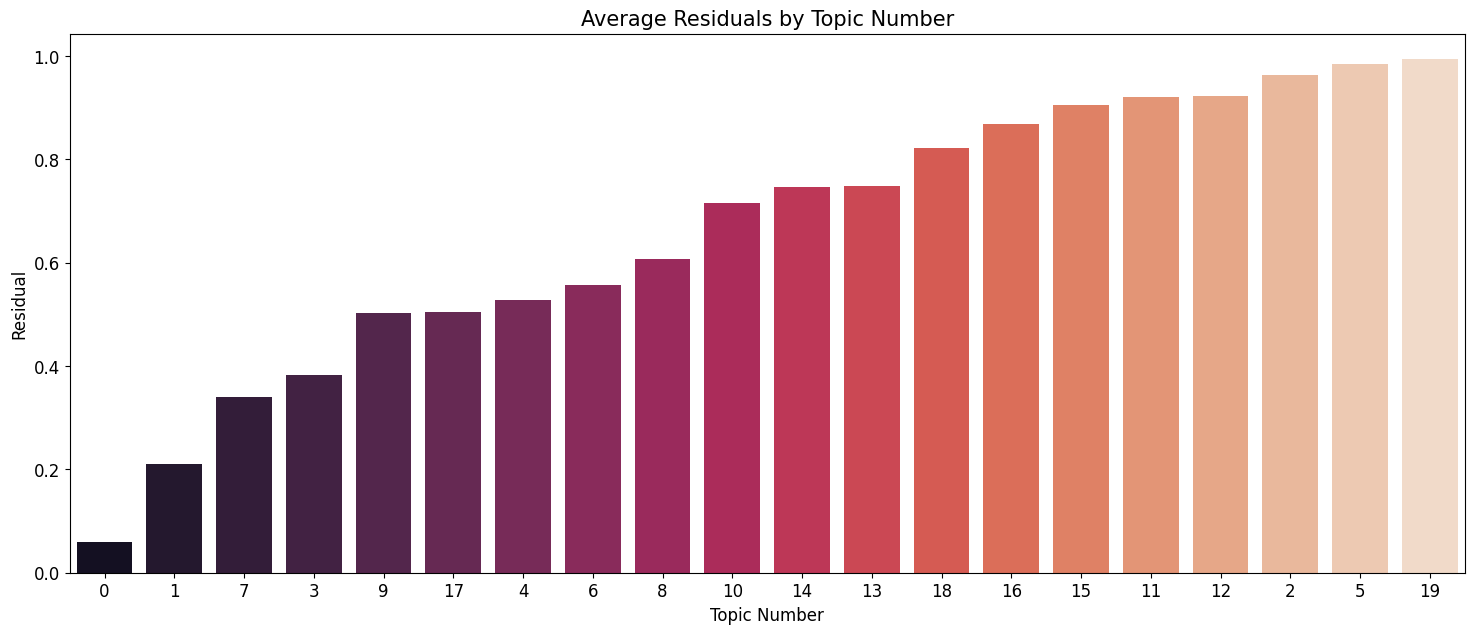

In [40]:
# Add the residuals calculated above to the final_topics
final_topics['resid'] = r

# Get the avg residual by topic so we can plot it
resid_data = final_topics[['topic_num', 'resid']].groupby('topic_num').mean().sort_values(by='resid')

# Plot a bar chart for the avg. residuls by topic
fig = plt.figure(figsize=(18,7))

x = resid_data.index
y = resid_data['resid']
    
g = sns.barplot(x=x, y=y, order=x, palette='rocket')

g.set_xticklabels(g.get_xticklabels(), fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Topic Number', fontsize=12)
plt.ylabel('Residual', fontsize=12)
plt.title('Average Residuals by Topic Number', fontsize=15)

plt.show()

From the residual bar chart above topics we will consider 0, 1, 7, 3, 9, 17, 4, 6, 8, 10, 14, 13 for naming because they are within reasonable residual value range.

In [41]:
topic_df[topic_df['topic_num'].isin([0, 1, 7, 3, 9, 17, 4, 6, 8, 10, 14, 13])]


,topic_num,topics
0,0,say passed bipartisan infrastructure bill protip democrat line literally call point someone republican want party pas
1,1,concession let movie republican ask bill demanded learn still deliver history seen time vote watered people weve infrastructure go
3,3,dictated republican deal expect vote cant voting yes already compromise would hard time true reading im bill trillion party infrastructure
4,4,budget proposal trillion counter responsible republican fiscally via infrastructure bill biden spending
6,6,th make priority infrastructure economy education health care news world report rank gov justice west according would
7,7,interested infrastructure isnt democratic support deal he joemanchin morgantown really repeatedly interview wrapped say bill ready think reconciliation bipartisan
8,8,spoiler alert watering bill succeed youre never getting gop wasting infrastructure senate vote time
9,9,trans bill anti jim justice stephanie ruhle gov destroyed rank among worst mentioning west child economy sport education banning bigoted morning gqp
10,10,spends infrastructure bill dollar trillion tax left price tag nothing multi
13,13,pothole bill profit pay think legalize call weed infrastructure still tax


##### **Topic labeling for NMF results**
Topic 0 - Bipartisan, Infrastructure bill, passed: **Solid Liberals (-4)**

Topic 1 - concession, republican, demanded, infrastructure: **Country First Conservatives (3)**

Topic 3 - Trillion dollar, cant compromise, infrastructure: **Country First Conservatives(3)**

Topic 7 - bipartisan, reconciliation, joemsnchin, infrastructure: **Devout and Diverse (-1)**

Topic 9 - anti-trans, economy, jim justice, stephanie ruhle, bigoted, anti-trans: **Core Conservatives (4)**

Topic 4 - fiscally responsible, counter, budget proposal, infrastructure: **Country First Conservatives (3)**

Topic 6 - priority, infrastructure, economy, education, health **care:Market Skeptic Republicans (2)**

Topic 8 - infrastructure, gop, waiting time, senate: **Core Conservatives (4)**

Topic 17 - idiotsan, jobsback, manufacturing, repub: **Core Conservatives (4)**

Topic 10 - trillion dollar, Infrastructure bill, waste: **Core Conservatives (4)**

Topic 14 - justin trudeau, lose money, cost: **Country First Conservatives (3)**

Topic 13 - pothole, legalize weed, wealthy tax: **Solid Liberals (-4)**

### 3.b Latent Dirichlet Allocation (LDA)

Ref: [8]

LDA says is that each word in each document comes from a topic and the topic is selected from a per-document distribution over topics. So we have two matrices:
1. ϴtd = P(t|d) which is the probability distribution of topics in documents
2. Фwt = P(w|t) which is the probability distribution of words in topics
And, we can say that the probability of a word given document i.e. P(w|d) is equal to:

                ∑_(t∈T)〖p(w│t,d)p(t|d)〗

where T is the total number of topics. Also, let’s assume that there is W number of words in our vocabulary for all the documents.
If we assume conditional independence, we can say that
P(w|t,d) = P(w|t)

And hence P(w|d) is equal to:
                  
                    ∑_(t=1)^T〖p(w│t)p(t|d)〗

that is the dot product of ϴtd and Фwt for each topic t.

Ref: [9]

**Steps on how LDA works:**

1. We want LDA to learn the topic mix in each question and the word mix in each topic.
2. Choose the number of topics we think there are in the entire question data set (example: num_topics = 2).
3. Randomly assign each word in each question to one of two topics
4. Go through every word and its topic assignment in each question. Look at 

  1) how often the topic occurs in the question and 

  2) how often the word occurs in the topic overall. Based on this   information, assign the word a new topic
  
5. Go through multiple iteration of this. Eventually the topics will start making sense in a way that we could interpret them and give them themes.

**Input**: Document-Term Matrix, number of topics

**Output**: The top words in each topic

#### Using gensim LDA multicore

**Import**

*corpora, models from gensim*: For creating dictionary

*CoherenceModel, LdaMulticore from gensim.models*: To create topics using LDA and calculate coherence score

*simple_preprocess from gensim.utils*: Processing tokens

*pyLDAvis.gensim*: Visualization library

*HdpModel from gensim.models*: Hierarchical Dirichlet Process to get best number of topics


In [ ]:
from gensim import corpora, models
from gensim.models import CoherenceModel, LdaMulticore
from gensim.utils import simple_preprocess
import pyLDAvis.gensim as pyldavis
import pyLDAvis
from gensim.models import HdpModel

In [ ]:
# Lda Code below ref: [10]
def preprocess(txt):
    r = [token for token in simple_preprocess(txt)]
    return r

proc_docs = df.text.apply(preprocess)

In [ ]:
# Prepare input for LDA algorithm
dictionary = corpora.Dictionary(proc_docs)
dictionary.filter_extremes(no_below=5, no_above= .85)

bow = [dictionary.doc2bow(doc) for doc in proc_docs]

In [ ]:
# Display to check values
bow[21][:2]
[(dictionary[id], freq) for id, freq in bow[21]]

In [ ]:
ts8 = time.time()
hdp = HdpModel(bow, dictionary, chunksize=10000)
print('Time taken for HdpModel to complete: %.2f' %(time.time() - ts8))

Time taken for HdpModel to complete: 342.63


In [ ]:
n = len(hdp.print_topics())  # Number of clusters we want to fit our data to

In [ ]:
ts9 = time.time()
'''
  Online Latent Dirichlet Allocation (LDA) in Python, using all CPU cores to parallelize and speed up model training.
  
  Parameters
  ----------
  corpus - Stream of document vectors or sparse matrix of shape
  num_topics - number of requested latent topics
  id2word - dict of mapping from word IDs to words
  passes - number of passes through the corpus during training
  workers - Number of workers processes to be used for parallelization
'''
lda = LdaMulticore(bow, num_topics= n, id2word=dictionary, passes=100, workers=5)
print('Time taken for multicore lda to complete: %.2f seconds' %(time.time() - ts9))

Time taken for multicore lda to complete: 5204.55 seconds


In [ ]:

for id, topic in lda.print_topics(-1):
    print(f"TOPIC: {id} \n WORDS: {topic}")

TOPIC: 0 
 WORDS: 0.060*"infrastructure" + 0.059*"plan" + 0.051*"biden" + 0.040*"trillion" + 0.037*"bill" + 0.031*"job" + 0.029*"joe" + 0.023*"american" + 0.022*"billion" + 0.020*"dollar"
TOPIC: 1 
 WORDS: 0.057*"cant" + 0.053*"deal" + 0.053*"already" + 0.051*"hard" + 0.049*"yes" + 0.043*"infrastructure" + 0.040*"party" + 0.038*"vote" + 0.036*"bill" + 0.034*"time"
TOPIC: 2 
 WORDS: 0.120*"job" + 0.106*"plan" + 0.066*"american" + 0.018*"biden" + 0.015*"create" + 0.013*"climate" + 0.011*"good" + 0.011*"america" + 0.010*"support" + 0.010*"build"
TOPIC: 3 
 WORDS: 0.047*"infrastructure" + 0.046*"biden" + 0.044*"bill" + 0.040*"gop" + 0.025*"democrat" + 0.023*"mcconnell" + 0.021*"mitch" + 0.019*"republican" + 0.017*"vote" + 0.015*"joe"
TOPIC: 4 
 WORDS: 0.023*"want" + 0.016*"nothing" + 0.013*"trump" + 0.011*"give" + 0.011*"border" + 0.010*"lie" + 0.009*"take" + 0.009*"get" + 0.009*"case" + 0.009*"way"
TOPIC: 5 
 WORDS: 0.054*"bill" + 0.049*"infrastructure" + 0.030*"biden" + 0.024*"first" + 0

**LDA Topic Labeling**

Topic 0 - trillion dollar infrastructure bill: **Solid Liberals (-4)**

Topic 1 - infrastructure bill cant vote: **Country First Conservatives (3)**

Topic 2 - infrastructure bill senate vote: **Country First Conservatives (3)**

Topic 3 - infrastructure bill progressive meet: **Opportunity Democrats (-3)**

Topic 4 - infrastructure bill bipartisan support: **New Era Enterprisers (1)**

Topic 5 - infrastructure bill water, road, bridge: **Opportunity Democrats (-3)**

Topic 6 - infrastructure bill and corporate tax: **Market Skeptic Republicans (2)**

Topic 7 - concessions: **Opportunity Democrats (-3)**

Topic 8 - new plan for american job and family: **Opportunity Democrats (-3)**

Topic 9 - construction cars: **New Era Enterprisers (1)**

Topic 10 - trump and election: **Core Conservatives (4)**

Topic 11 - infrastructure bill in budget spending proposal: **Market Skeptic Republicans (2)**

Topic 12 - middle class, infrastructure bill, covid relief: **Opportunity Democrats (-3)**

Topic 13 - priority: child care, education, health, economy: **Opportunity Democrats (-3)**

Topic 14 - president joe biden infrastructure bill and republican: **Core Conservatives (4)**

Topic 15 - job plan, get  back to work: **Opportunity Democrats (-3)**

Topic 16 - american job plan, climate, energy: **Opportunity Democrats (-3)**

Topic 17 - new project critical for city, state, national: **New Era Enterprisers (1)**

Topic 18 - infrastructure bill vote democrat, republican: **Market Skeptic Republicans (2)**

Topic 19 - infrastructure louisiana: **Any**

Our model will be better if the words in a topic are similar, so we will use topic coherence to evaluate our model. Topic coherence evaluates a single topic by measuring the degree of semantic similarity between high scoring words in the topic. A good model will generate topics with high topic coherence scores.

A good topic model will have big and non-overlapping bubbles scattered throughout the chart.

In [ ]:
### Coherence Scoring ###
ts10 = time.time()
coh = CoherenceModel(model=lda, texts= proc_docs, dictionary = dictionary, coherence = "c_v")
coh_lda = coh.get_coherence()
print("Coherence Score:", coh_lda)

lda_display = pyldavis.prepare(lda, bow, dictionary)
print('Time taken for coherence score and display topics: %.2f' %(time.time() - ts10))
pyLDAvis.display(lda_display)

Coherence Score: 0.5295357135106653
Time taken for coherence score and display topics: 54.95


**Observations:**

The topics are not all distinct, which might be possible with a better coherence of about 65% whereas we achieved only ~53%. 

Tried to change passes, num_topics, workers which did not make a lot of difference. There must be a way a to provide ngram so the model can consider 2 words together in a topic, ldaMulticore looks like does not have that parameter. 

Words like infrastucture is repeated in quite a few topics making them intersect with each other.

### 3.c Models tried and did not work as expected

#### K-Means
Tried to use K-Means to create clusters. Got the topics created, however the K-Means clustering results did not look very helpful for my analysis. Leaving the code here in case someone wants to take a look (**Ref**: https://twitterdev.github.io/do_more_with_twitter_data/clustering-users.html)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
import numpy as np
from bokeh.models import HoverTool
from bokeh.palettes import brewer, Viridis256
import seaborn as sns
from bokeh.plotting import figure, ColumnDataSource, show, output_notebook; output_notebook()

In [ ]:
kmean_df = df['text']
tf_idf_vectorizor = TfidfVectorizer(max_features = 20000)
tf_idf = tf_idf_vectorizor.fit_transform(kmean_df)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()
# tf_idf_array

In [ ]:
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()

,aadmi,aam,aapl,aata,ab,abbott,abbottnoth,abbottwher,abet,abil,abl,abolish,abomin,abort,abound,aboutbipartisan,abouttennessean,abroad,absenc,absolut,abt,abus,aca,academ,academi,acc,acceler,accept,acceso,access,accessbl,accid,accommod,accomplic,accomplish,accord,account,accru,accrual,accur,...,xbiden,ya,yacht,yahoo,yakabuski,yall,yammer,yang,yard,yawn,ye,yea,yeah,year,yell,yep,yesterday,yo,yon,york,youll,young,youth,youtub,youv,yr,yuan,yuge,yuh,yup,yurek,zdnet,zealand,zealou,zeldin,zero,zip,zone,zoologist,zvobgo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def strongest_features(model, vectorizer, topk=10):
    """
    Helper function to display a simple text representation of the top-k most
    important features in our fit model and vectorizer.

    model: sklearn model
    vectorizer: sklearn vectorizer
    topk: k numbers of words to get per cluster

    """
    # these parts are model-independent
    m_name = model.__class__.__name__
    features = vectorizer.get_feature_names()
    # different calculations per model type
    if m_name is 'KMeans':
        relevant_labels = list(set(model.labels_))
        centroids = model.cluster_centers_.argsort()[:,::-1]
        for this_label in relevant_labels:
            print('Cluster {}:'.format(this_label), end='')
            for ind in centroids[this_label, :topk]:
                print(' {}'.format(features[ind]), end='')
            print()
    elif m_name is 'HDBSCAN':
        # ignore noise labels
        relevant_labels = [ x for x in set(model.labels_) if x >= 0 ]
        for this_label in relevant_labels:
            matching_rows = np.where(hdbs.labels_ == this_label)[0]
            coeff_sums = np.sum(bio_matrix[matching_rows], axis=0).A1
            sorted_coeff_idxs = np.argsort(coeff_sums)[::-1]
            print('Cluster {}: '.format(this_label), end='')
            for idx in sorted_coeff_idxs[:topk]:
                print('{} '.format(features[idx]), end='')
            print()
    else:
        raise NotImplementedError('This helper method currently only supports KMeans and HDBSCAN models')

In [ ]:
# compare a broad range of ks to start
# ks = [2, 50, 200, 500]
ks = [50, 200]

# track a couple of metrics
sil_scores = []
inertias = []

# fit the models, save the evaluation metrics from each run
for k in ks:
    print('fitting model for {} clusters'.format(k))
    model = KMeans(n_clusters=k, n_jobs=-1, random_state=200)
    model.fit(tf_idf_array)
    labels = model.labels_
    sil_scores.append(silhouette_score(tf_idf_array, labels))
    inertias.append(model.inertia_)

# plot the quality metrics for inspection
fig, ax = plt.subplots(2, 1, sharex=True)

plt.subplot(211)
plt.plot(ks, inertias, 'o--')
plt.ylabel('inertia')
plt.title('kmeans parameter search')

plt.subplot(212)
plt.plot(ks, sil_scores, 'o--')
plt.ylabel('silhouette score')
plt.xlabel('k');

In [ ]:
smaller_k = 20
km_model = KMeans(n_clusters=smaller_k, n_jobs=-1, random_state=200)
km_model.fit(tf_idf_array)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=200, tol=0.0001, verbose=0)

In [ ]:
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

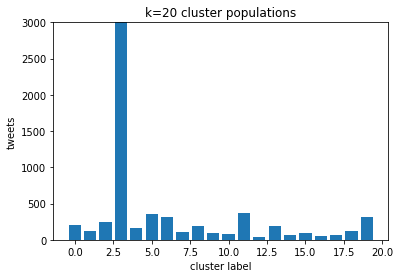

In [ ]:
plt.bar(range(len(set(km_model.labels_))), np.bincount(km_model.labels_))

plt.ylabel('tweets')
plt.xlabel('cluster label')
plt.title('k={} cluster populations'.format(smaller_k));

# truncating the axis again!
plt.ylim(0,3000);

In [ ]:
strongest_features(km_model, tf_idf_vectorizor, topk=15)

Cluster 0: capito moor negoti shelley presid biden senat republican deal meet gop useless faith bipartisan continu
Cluster 1: possibl real compromis senat republican infrastructur republicansen capito shelley moor say presid biden hope senatormor
Cluster 2: tel regularli bella oblivion aviv hadid apartheid decim blown bomb occupi isra prison open air
Cluster 3: infrastructur biden pas need work plan gop want vote senat care republican democrat bridg support
Cluster 4: face challeng suffici realiti unit schumer disappoint reconcili meet support state time senat biden republican
Cluster 5: propos budget trillion fiscal counter respons republican bee babylon thetuniswamp boondoggl sad yep beerepublican malic
Cluster 6: pay buttigieg level high secretari tax fox discus pete crazi share fair wealthi corpor got
Cluster 7: foment kabuki deepli theater riot involv result buy execut attempt capitol line hard exactli coup
Cluster 8: kirsten ny gillibrand clear wast stop sen think want negoti mak

In [ ]:
# TODO - Get this to work for proper plotting of clusters
# create one entry per user
# unique_user_map = {t.user_id: t.id for t in df}
unique_users = df['user_id'].unique()
# we need to maintain the same ordering of users and bios
# unique_users = []
# unique_bios = []
# for user,bio in unique_user_map.items():
#     unique_users.append(user)
#     if bio is None:
#         # special case for empty bios
#         bio = ''
#     unique_bios.append(bio)

In [ ]:
pca = PCA(n_components=2, random_state=200)
df_matrix_2d = pca.fit_transform(tf_idf.todense())

In [ ]:
def get_plottable_df(users, tweets, two_d_coords, labels):
    """
    Combine the necessary pieces of data to create a data structure that plays
    nicely with the our 2d tsne chart.

    Note: assumes that all argument data series
    are in the same order e.g. the first user, bio, coords, and label
    all correspond to the same user.
    """
    # set up color palette
    num_labels = len(set(labels))
    colors = sns.color_palette('hls', num_labels).as_hex()
    color_lookup = {v:k for k,v in zip(colors, set(labels))}
    
    # combine data into a single df
    df = pd.DataFrame({'uid': users,
                       'text': tweets,
                       'label': labels,
                       'x_val': two_d_coords[:,0],
                       'y_val': two_d_coords[:,1],
                      })
    
    # convert labels to colors
    df['color'] = list(map(lambda x: color_lookup[x], labels))
    return df

In [ ]:
km_plottable_bios = get_plottable_df(df['user_id'], df['text'], df_matrix_2d, km_model.labels_)
km_plottable_bios.head()

,uid,text,label,x_val,y_val,color
0,49422239,true mr presid seem beyond presidenti power ge...,3,-0.009150,-0.082671,#dbd657
1,1126818066,weve seen movi republican ask concess concess ...,3,0.025310,-0.046148,#dbd657
2,16041234,joe manchin infrastructur bill must bipartisan,3,-0.005839,-0.090881,#dbd657
3,1321982917426425858,weve seen movi republican ask concess concess ...,3,0.025310,-0.046148,#dbd657
4,881759407729672193,weve seen movi republican ask concess concess ...,3,0.025310,-0.046148,#dbd657


In [ ]:
def plot_pca(df, title='PCA plot'):
    # add our DataFrame as a ColumnDataSource for Bokeh
    plot_data = ColumnDataSource(df)
    # configure the chart
    pca_plot = figure(title=title, plot_width=800, plot_height=700, tools=('pan, box_zoom, reset'))
    # add a hover tool to display words on roll-over
    pca_plot.add_tools(
        HoverTool(tooltips = """<div style="width: 400px;">(@label) @text</div>""")
    )
    # draw the words as circles on the plot
    pca_plot.circle('x_val', 'y_val',
                     source=plot_data,
                     color='color',
                     line_alpha=0.2,
                     fill_alpha=0.1,
                     size=7,
                     hover_line_color='black')
    # configure visual elements of the plot
    pca_plot.title.text_font_size = '12pt'
    pca_plot.xaxis.visible = False
    pca_plot.yaxis.visible = False
    pca_plot.grid.grid_line_color = None
    pca_plot.outline_line_color = None
    return pca_plot

In [ ]:
show(plot_pca(km_plottable_bios.sample(5000), 'kmeans-clustered topics'))

#### Using sklearn LDA - **slow, wont work**

In [ ]:
# Run LDA with best param identified in previous step
# no_clusters = 15
# ts8 = time.time()

# lda_model = LatentDirichletAllocation(n_components=no_clusters, max_iter=50, learning_method='online', random_state=43,
#                                      batch_size=128, evaluate_every=-1, n_jobs=-1)

# # fit transform the feature matrix
# lda_output = lda_model.fit_transform(feature_matrix)

# print('Time taken for LDA model fit for best combo: %.2f seconds' %(time.time() - ts8))
# display(lda_output)


In [ ]:
# Compare the LDA performance score
# df_cv_results = pd.DataFrame(model.cv_results_)
# df_cv_results.to_csv("LDAGridSearchResults.csv", header=True, index=False, encoding='utf-8')

In [ ]:
# sns.pointplot(x="param_n_components", y="mean_test_score", hue="param_learning_decay", data=df_cv_results)

In [ ]:
# Added to avoid 'OSError: [Errno 28] No space left on device' while running lda fit
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


*Import*:

*from sklearn.feature_extraction.text import CountVectorizer*: Create document term matrix

*from sklearn.decomposition import LatentDirichletAllocation*: Apply LDA topic modeling on the text data

*from sklearn.model_selection import GridSearchCV*: Gridsearch to find best algorithm parameters


In [ ]:
# for LDA
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [ ]:
# vectorize the corpus
''' max_df: ignore terms that have a document frequency strictly higher than 95%, 
    min_df: ignore terms that have a document frequency strictly lower than 10 '''
ts7 = time.time()
count_vectorizer = CountVectorizer(min_df=10, max_df=0.95, ngram_range=(1,1), stop_words='english')

# calculate the feature matrix
feature_matrix = count_vectorizer.fit_transform(df['text'])

print('Time taken to create CountVector for LDA: %.2f seconds' %(time.time() - ts7))
display(feature_matrix)

Time taken to create CountVector for LDA: 2.66 seconds


<157784x10134 sparse matrix of type '<class 'numpy.int64'>'
	with 2119351 stored elements in Compressed Sparse Row format>

In [ ]:
# A model with higher log-likelihood and lower perplexity is preferred.
# print("Log likelihood: ", lda_model.score(feature_matrix))
# print("Perplexity: ", lda_model.perplexity(feature_matrix))

**GridSearchCV**: will apply lda to different combination of number of topics to find best params.

A model with higher log-likelihood and lower perplexity is preferred.

In [ ]:
# GridSearch the best LDA model
# This will take sometime to run because we have lot of data

ts5 = time.time()
# Define Search Param
# Below combination took 4.2 hours to complete for large dataset, 0.7 and 15 as best param
# search_params = {'n_components': [15, 20, 25], 'learning_decay': [.7, .8, .9]}

# Use this for small & medium sets to finish faster
search_params = {'n_components': [15, 20], 'learning_decay': [.7, .8]}    

# Init the model
lda = LatentDirichletAllocation()

# Init Grid Search class
model = GridSearchCV(lda, search_params)

model.fit(feature_matrix)
best_lda_model = model.best_estimator_
print('Time taken complete gridSearch for best model: %.2f' %(time.time() - ts5))
print("Best model's params: ", model.best_params_)
print("Best log likelihood score: ", model.best_score_)
print("Model perplexity: ", best_lda_model.perplexity(feature_matrix))

Time taken complete gridSearch for best model: 15212.58
Best model's params:  {'learning_decay': 0.7, 'n_components': 15}
Best log likelihood score:  -3610576.7646851502
Model perplexity:  1062.7601065644694


# References for code
1] https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/

2] https://realpython.com/python-nltk-sentiment-analysis/ 

3] https://towardsdatascience.com/topic-modeling-quora-questions-with-lda-nmf-aff8dce5e1dd 

4] https://github.com/akshayjoshii/COVID19-Tweet-Sentiment-Analysis-and-EDA/blob/master/Exploratory_Data_Analysis.ipynb 

5] https://shravan-kuchkula.github.io/topic-modeling/#build-nmf-model-using-sklearn 

6] https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

7] https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45

8] https://medium.com/analytics-vidhya/topic-modeling-using-lda-and-gibbs-sampling-explained-49d49b3d1045 

9] https://towardsdatascience.com/topic-modeling-quora-questions-with-lda-nmf-aff8dce5e1dd 

10] https://towardsdatascience.com/exploring-textual-data-using-lda-ef1f53c772a4
